In [1]:
%config InlineBackend.figure_format = 'retina'

In [64]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

import re
import os
import cv2
import math
import scipy
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from adjustText import adjust_text
from glob import glob
from copy import deepcopy
from multiprocessing import Pool
from scipy.cluster import hierarchy
from pyBedGraph import BedGraph
from bs4 import BeautifulSoup
from scipy.stats import chi2_contingency, hypergeom, pearsonr, variation, ttest_ind, zscore
from matplotlib_venn import venn2, venn2_circles

import matplotlib.pyplot as plt
import seaborn as sns

# Fig 3A

In [3]:
motif_pvalue_df = pd.read_csv('./Data/tf_hyper_pvals.all.csv', index_col=0)

In [4]:
log_motif_pvalue_df = motif_pvalue_df.applymap(lambda x:-math.log10(x) if x!=0 else 350).T

In [5]:
cut_log_pval = 5

filter_log_motif_pvalue_df = log_motif_pvalue_df.loc[log_motif_pvalue_df.max(axis=1)>cut_log_pval]

In [6]:
filter_tfs = []
for tf in filter_log_motif_pvalue_df.index:
    if not re.search('-VAR', tf):
        filter_tfs.append(tf)
#     else:
#         print(tf)
len(filter_tfs)

241

In [19]:
filter_log_motif_pvalue_df = filter_log_motif_pvalue_df.loc[filter_tfs]

In [7]:
corr_df = filter_log_motif_pvalue_df.T.corr()

In [8]:
def cal_tfidf(data): 
    data=scipy.sparse.csr_matrix(data.T)

    peaks=data.sum()
    tf=(data/peaks)

    idf=data.shape[1]/data.sum(axis=1)

    tfidf=np.dot(scipy.sparse.diags(np.squeeze(np.asarray(idf))),tf)
    
    tfidf=pd.DataFrame(tfidf.todense())
    
    
    return tfidf

In [9]:
zscore_filter_log_motif_pvalue_df = pd.DataFrame(zscore(filter_log_motif_pvalue_df, axis=1), 
                                                 index=filter_log_motif_pvalue_df.index, 
                                                 columns=filter_log_motif_pvalue_df.columns)

In [10]:
t=cal_tfidf(zscore_filter_log_motif_pvalue_df).T
order=t.apply(lambda x: x.argmax(),axis=1)
order.index=zscore_filter_log_motif_pvalue_df.index
order.columns=zscore_filter_log_motif_pvalue_df.columns

In [11]:
pseudo_df = pd.read_csv('./Data/dim30_F1200_R07.pseudo', index_col=0)
pseudo_df = pseudo_df.sort_values(by='Pseudotime')

In [12]:
nb_cell = pseudo_df.shape[0]
order_pseudo_cells = pseudo_df.index.tolist()

In [13]:
cell_parts = []
nb_metaCell = 500
nb_step = 50
prefixs = []
pseudo_time_ls = []

for i in range(1000):
    prefixs.append('s'+str(i))
    tmp_start = i*nb_step
    tmp_end = nb_metaCell+i*nb_step
    if tmp_end > nb_cell:
        tmp_end = deepcopy(nb_cell)
        cell_parts.append(order_pseudo_cells[tmp_start:tmp_end])
        pseudo_time_ls.append(pseudo_df.loc[order_pseudo_cells[tmp_start:tmp_end],'Pseudotime'].mean())
        break
    cell_parts.append(order_pseudo_cells[tmp_start:tmp_end])
    pseudo_time_ls.append(pseudo_df.loc[order_pseudo_cells[tmp_start:tmp_end],'Pseudotime'].mean())

In [14]:
pearson_pseudo_time_ls = []

for tf in filter_log_motif_pvalue_df.index.tolist():
    pearson_pseudo_time_ls.append(pearsonr(filter_log_motif_pvalue_df.loc[tf], pseudo_time_ls)[0])

In [15]:
tf_corr_time_df = pd.DataFrame({'corr':pearson_pseudo_time_ls}, index=filter_log_motif_pvalue_df.index)

In [16]:
colors = list(sns.color_palette('PiYG_r',201).as_hex())
tf_corr_time_df['c'] = tf_corr_time_df['corr'].map(lambda x:colors[int(x*100+100)])

In [17]:
early_tfs = tf_corr_time_df[tf_corr_time_df['corr']<0].index.tolist()
late_tfs = tf_corr_time_df[tf_corr_time_df['corr']>0].index.tolist()

In [18]:
mean_tf_df = pd.read_csv('./Data/tf_mean_pseudotime.csv', index_col=0)

In [19]:
order_zscore_filter_log_motif_pvalue_df = zscore_filter_log_motif_pvalue_df.loc[mean_tf_df.sort_values('pseudotime').index]

In [26]:
gsb_df = pd.DataFrame(cv2.GaussianBlur(filter_log_motif_pvalue_df.loc[mean_tf_df.sort_values('pseudotime').index].values, kernel_size, sigma), index=mean_tf_df.sort_values('pseudotime').index)

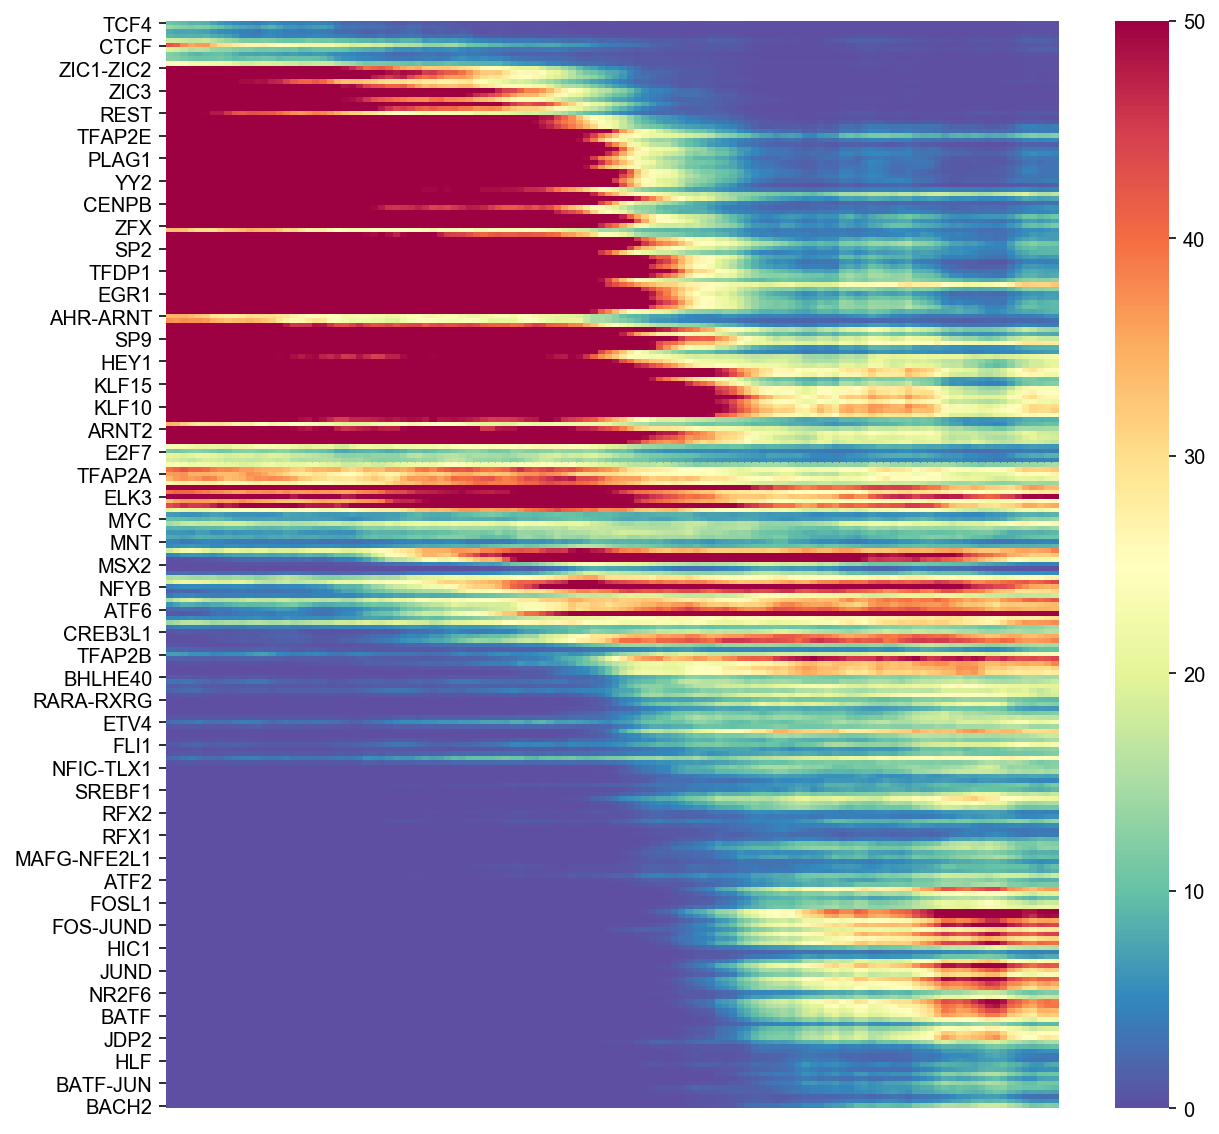

In [27]:
sigma = 2
kernel_size = (5, 5)

fig = plt.figure(figsize=(10,10))
ax21 = plt.subplot(111)

sns.heatmap(gsb_df, cmap='Spectral_r', vmin=0, vmax=50, xticklabels=False)

# Fig 3C

In [31]:
nfya_target_peaks = [x.strip().split('\t')[3] for x in open('./Data/merge.nfya_binding.peaks.bed').readlines()]

In [32]:
neg_corr_tfs = list(np.loadtxt('./Data/negative_corr.tf.txt', dtype=str))
pos_corr_tfs = list(np.loadtxt('./Data/positive_corr.tf.txt', dtype=str))

In [35]:
tf_mean_df = pd.read_csv('./Data/tf_mean_pseudotime2.csv', index_col=0)
tf_mean_df = tf_mean_df.sort_values('pseudotime')

In [37]:
tf_peak_df = pd.read_csv('./Data/motif_peak.csv', index_col=0)

In [38]:
tf_pval_df = pd.read_csv('./Data/tf_hyper_pvals.all.csv', index_col=0).T

In [39]:
filter_tf_pval_df = tf_pval_df.loc[tf_mean_df.sort_values('pseudotime').index].applymap(lambda x:-math.log10(x) if x!=0 else 350)

In [40]:
filter_tfs = filter_tf_pval_df.index.tolist()

In [41]:
neg_corr_tfs = list(set([x.split('-VAR')[0] for x in neg_corr_tfs]))

In [42]:
neg_tf_std = np.std(tf_mean_df.loc[list(set(neg_corr_tfs).intersection(tf_mean_df.index)),'pseudotime'])
pos_tf_std = np.std(tf_mean_df.loc[list(set(pos_corr_tfs).intersection(tf_mean_df.index)),'pseudotime'])

In [43]:
pos_tfs = list(set(pos_corr_tfs).intersection(tf_mean_df.index))
pos_tfs.sort()

In [44]:
neg_tfs = list(set(filter_tfs)-set(pos_tfs))
neg_tfs.sort()

In [46]:
peak_count_df = pd.read_csv('./Data/peak_order.csv', index_col=0)

In [47]:
all_peaks = peak_count_df.index.tolist()

In [48]:
pos_corr_tfs = list(set(pos_corr_tfs).intersection(tf_mean_df.index))

In [51]:
peak_class_dict = {}

In [52]:
prefixs = ['sc_bookmarked','unbookmarked']
for prefix in prefixs:
    peak_file = './Data/'+prefix+'.peaks.bed'
    peak_class_dict[prefix] = [x.strip().split('\t')[3] for x in open(peak_file).readlines()]

In [53]:
all_targets_tf = tf_mean_df.index.tolist()

In [55]:
peak_anno_df = pd.read_csv('./Data/top_filtered_peak.anno.txt', 
                           index_col=0, sep='\t')

In [56]:
cut_dist = 2500

In [57]:
proximal_peak_anno_df = peak_anno_df[abs(peak_anno_df['Distance to TSS'])<=cut_dist]

In [58]:
acc_min_time = np.array(peak_count_df.mean(axis=0)).argmin()
acc_min_time

59

In [59]:
tf_lost_target_dict = {}
tf_enrich_target_dict = {}

tmp_df = peak_count_df.iloc[:,:acc_min_time].sum(axis=1)
lost_peaks = tmp_df[tmp_df>0].index.tolist()
for tf in tf_mean_df.index:
    tmp_df = tf_peak_df.loc[lost_peaks,tf]
    tf_peaks = list(set(tmp_df[tmp_df>0].index.tolist()).intersection(set(proximal_peak_anno_df.index)))
    tf_target_tfs = list(set(proximal_peak_anno_df.loc[tf_peaks,'Gene Name']).intersection(set(all_targets_tf)))
    
    tf_lost_target_dict[tf] = tf_target_tfs
    
    
tmp_df = peak_count_df.iloc[:,acc_min_time:].sum(axis=1)
enrich_peaks = tmp_df[tmp_df>0].index.tolist()
for tf in tf_mean_df.index:
    tmp_df = tf_peak_df.loc[enrich_peaks,tf]
    tf_peaks = list(set(tmp_df[tmp_df>0].index.tolist()).intersection(set(proximal_peak_anno_df.index)))
    tf_target_tfs = list(set(proximal_peak_anno_df.loc[tf_peaks,'Gene Name']).intersection(set(all_targets_tf)))
    
    tf_enrich_target_dict[tf] = tf_target_tfs

In [61]:
tmp_time_ls = []
tmp_ratio_ls = []
tmp_tf_ls = []
tmp_type_ls = []

for prefix in prefixs:
    prefix_peaks = peak_class_dict[prefix]


    for tf in pos_corr_tfs:
        tmp_df = tf_peak_df.loc[enrich_peaks,tf]
        tf_peaks = tmp_df[tmp_df>0].index.tolist()
        tf_prefix_peaks = list(set(tf_peaks).intersection(set(prefix_peaks)))
        if len(tf_peaks) != 0:
            ratio = len(tf_prefix_peaks) / len(tf_peaks)

            tmp_time_ls.append(tf_mean_df.loc[tf,'pseudotime'])
            tmp_ratio_ls.append(ratio)
            tmp_tf_ls.append(tf)
            tmp_type_ls.append(prefix)

result_ratio_df = pd.DataFrame({'time':tmp_time_ls, 'ratio':tmp_ratio_ls, 'type':tmp_type_ls}, index=tmp_tf_ls)

sc_bookmarked (-0.6898176601728334, 8.099549364388944e-20)


19

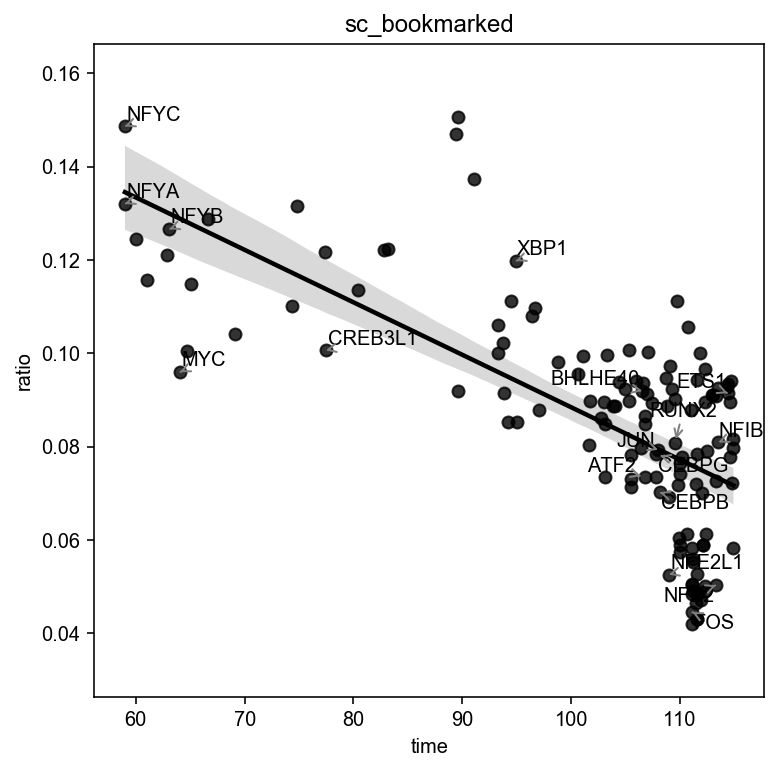

In [65]:
enrich_tfs = ['NFYA','NFYB','NFYC','MYC','CREB3L1',
              'XBP1','BHLHE40','ATF2','CEBPB','JUN',
              'RUNX2','NFE2L1','FOS','ETS1','NFIB',
              'NFE2','CEBPG']


prefix = 'sc_bookmarked'
sel_result_ratio_df = result_ratio_df[result_ratio_df['type']==prefix]

fig = plt.figure(figsize=(6,6))
ax21 = plt.subplot(111)
g = sns.regplot(x=sel_result_ratio_df['time'], y=sel_result_ratio_df['ratio'], ax=ax21, color='black')
_ = ax21.set_title(prefix)
print(prefix, pearsonr(sel_result_ratio_df['time'], sel_result_ratio_df['ratio']))
texts = [ax21.text(sel_result_ratio_df.loc[tf,'time'],sel_result_ratio_df.loc[tf,'ratio'],tf) for tf in enrich_tfs]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))